In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from tensorflow.python.framework import ops
from cnn_utils import *
np.random.seed(1)
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
x_train, y_train, x_test, y_test, classes = load_dataset()

y = 5


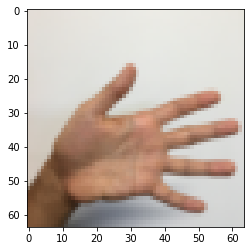

In [3]:
plt.imshow(x_train[0])
print("y = " + str(np.squeeze(y_train[:,0])))

In [4]:
x_train = x_train/255.
x_test = x_test/255.
y_train = convert_to_one_hot(y_train, 6).T
y_test =  convert_to_one_hot(y_test, 6).T
print("Number of training examples = " + str(x_train.shape[0]))
print("Number of test examples = " + str(x_test.shape[0]))
print("x_train shape = " + str(x_train.shape))
print("x_test = " + str(x_test.shape))
print("y_train shape = " + str(y_train.shape))
print("y_test = " + str(y_test.shape))
conv_layers = {}

Number of training examples = 1080
Number of test examples = 120
x_train shape = (1080, 64, 64, 3)
x_test = (120, 64, 64, 3)
y_train shape = (1080, 6)
y_test = (120, 6)


In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    x = tf.compat.v1.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    y = tf.compat.v1.placeholder(tf.float32, [None, n_y])
    return x,y
    

In [6]:
print(tf.__version__)
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

2.4.0
X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [7]:
def initialize_parameters():
    tf.compat.v1.set_random_seed(1)
    W1 = tf.compat.v1.get_variable("W1", [4,4,3,8], initializer = tf.compat.v1.keras.initializers.glorot_uniform(seed=0))
    W2 = tf.compat.v1.get_variable("W2", [2,2,8,16], initializer = tf.compat.v1.keras.initializers.glorot_uniform(seed=0))
    parameters = {"W1" : W1,
                  "W2" : W2}
    return parameters

In [8]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [9]:
from tensorflow import keras
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    Z1 = tf.compat.v1.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    A1 = tf.compat.v1.nn.relu(Z1)
    P1 = tf.compat.v1.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding ="SAME")
    Z2 = tf.compat.v1.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2 = tf.compat.v1.nn.relu(Z2)
    P2 = tf.compat.v1.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = "SAME")
    P = tf.compat.v1.layers.flatten(P2)
    Z3 = tf.compat.v1.layers.dense(P, 6, activation=None)
    return Z3
    

In [10]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 0.9927579  -1.9926488   0.40574205 -1.0828865   0.5642381  -1.7546117 ]
 [ 0.93642586 -1.8676597   0.10536456 -1.0255287   0.7649098  -1.9162732 ]]


C:\Users\meetd\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
C:\Users\meetd\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\meetd\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


In [11]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels =Y))
    return cost

In [12]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y:np.random.randn(4,6)})
    print("Cost = " + str(a))

Cost = 2.695238


In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epochs = 100, minibatch_size = 64, print_cost =True):
    ops.reset_default_graph()
    tf.compat.v1.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and epoch%5==0:
                print("Cost after epoch {} : {}".format(epoch, minibatch_cost))
            if print_cost == True and epoch%1==0:
                costs.append(minibatch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

C:\Users\meetd\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
C:\Users\meetd\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\meetd\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


Cost after epoch 0 : 1.917299635708332
Cost after epoch 5 : 1.677077017724514
Cost after epoch 10 : 0.9828307516872883
Cost after epoch 15 : 0.7407933920621872
Cost after epoch 20 : 0.5115265566855669
Cost after epoch 25 : 0.42088971100747585
Cost after epoch 30 : 0.35969770047813654
Cost after epoch 35 : 0.32027685083448887
Cost after epoch 40 : 0.28114498034119606
Cost after epoch 45 : 0.24407089548185468
Cost after epoch 50 : 0.19896329008042812
Cost after epoch 55 : 0.1786839971318841
Cost after epoch 60 : 0.16206553811207414
Cost after epoch 65 : 0.15422361763194203
Cost after epoch 70 : 0.1286064963787794
Cost after epoch 75 : 0.13901575398631394
Cost after epoch 80 : 0.13717522285878658
Cost after epoch 85 : 0.11046412633731961
Cost after epoch 90 : 0.0835506219882518
Cost after epoch 95 : 0.09242447896394879
Cost after epoch 100 : 0.09128866135142744
Cost after epoch 105 : 0.0640189757104963
Cost after epoch 110 : 0.0883987455163151
Cost after epoch 115 : 0.05719455785583705
Co

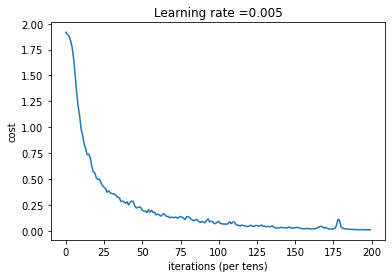

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.9166667


In [16]:
_, _, parameters = model(x_train, y_train, x_test, y_test, num_epochs=200, learning_rate=0.005)

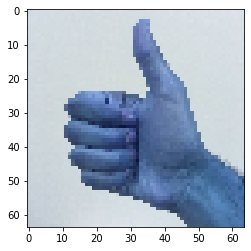

In [17]:
import cv2
fname = "images/thumbs_up.jpg"
image = cv2.imread(fname)
my_image = cv2.resize(image, (64,64))
plt.imshow(my_image)